# US Airline Flight Routes and Fares 1993-2024

## Business Understanding
This analysis aims to identify the key factors that influence airline fare prices using a dataset containing detailed information on U.S. domestic flight routes from 1993 to 2024. The insights derived from this analysis will help airlines, travel agencies, and policy makers optimize pricing strategies, improve route planning, and better understand competitive dynamics in the air travel market.

## Data Understanding
The dataset provides comprehensive information on airline flight routes, fares, and passenger volumes within the United States over a span of three decades. It includes metrics such as origin and destination cities and airports, distances between airports, number of passengers, and fare details segmented by different carriers (including the largest carrier and the lowest fare carrier). This rich set of features enables an in-depth analysis of air travel trends, pricing behavior, and market share dynamics.


### Data Dictionary
- `tbl`: Table identifier
- `year`: Year of the data record
- `quarter`: Quarter of the year (1–4)
- `citymarketid_1`: Origin city market ID
- `citymarketid_2`: Destination city market ID
- `city1`: Origin city name
- `city2`: Destination city name
- `airportid_1`: Origin airport ID
- `airportid_2`: Destination airport ID
- `airport_1`: Origin airport code
- `airport_2`: Destination airport code
- `nsmiles`: Distance between airports in miles
- `passengers`: Number of passengers
- `fare`: Average fare
- `carrier_lg`: Code for the largest carrier by passengers
- `large_ms`: Market share of the largest carrier
- `fare_lg`: Average fare of the largest carrier
- `carrier_low`: Code for the lowest fare carrier
- `lf_ms`: Market share of the lowest fare carrier
- `fare_low`: Lowest fare
- `Geocoded_City1`: Geocoded coordinates for the origin city
- `Geocoded_City2`: Geocoded coordinates for the destination city
- `tbl1apk`: Unique identifier for the route

In [1]:
# Standard library imports
import os
import warnings
import time
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# SHAP
import shap

# Joblib
import joblib

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

## Data Loading

Let's load the dataset and perform an initial exploration to understand its structure and contents.

In [2]:
# Download dataset
filename = 'us-airline-flight-routes-and-fares-1993-2024.zip'
if not os.path.exists(filename):
  !curl -L -o us-airline-flight-routes-and-fares-1993-2024.zip \
    https://www.kaggle.com/api/v1/datasets/download/bhavikjikadara/us-airline-flight-routes-and-fares-1993-2024

# Load the dataset
data = pd.read_csv(filename)

# Display basic information
print(f"Dataset shape: {data.shape}")
print("\nFirst 5 rows:")
display(data.head())

# Basic statistics
print("\nBasic statistics:")
display(data.describe(include='all'))

# Check for missing values
print("\nMissing values per column:")
display(data.isnull().sum().sort_values(ascending=False))

# Check data types
print("\nData types:")
display(data.dtypes)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 13.0M  100 13.0M    0     0  17.7M      0 --:--:-- --:--:-- --:--:-- 47.1M
Dataset shape: (245955, 23)

First 5 rows:


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
0,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,14112,ABE,PIE,970,180,81.43,G4,1.0000,81.43,G4,1.0000,81.43,NaN,NaN,202131013514112ABEPIE
1,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,15304,ABE,TPA,970,19,208.93,DL,0.4659,219.98,UA,0.1193,154.11,NaN,NaN,202131013515304ABETPA
2,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11259,ABQ,DAL,580,204,184.56,WN,0.9968,184.44,WN,0.9968,184.44,NaN,NaN,202131014011259ABQDAL
3,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11298,ABQ,DFW,580,264,182.64,AA,0.9774,183.09,AA,0.9774,183.09,NaN,NaN,202131014011298ABQDFW
4,Table1a,2021,3,30140,30466,"Albuquerque, NM","Phoenix, AZ",10140,14107,ABQ,PHX,328,398,177.11,WN,0.6061,184.49,AA,0.3939,165.77,NaN,NaN,202131014014107ABQPHX



Basic statistics:


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
count,245955,245955.000000,245955.000000,245955.000000,245955.000000,245955,245955,245955.000000,245955.000000,245955,245955,245955.000000,245955.000000,245955.000000,244415,244415.000000,244415.000000,244343,244343.000000,244343.000000,206749,206749,245955
unique,2,NaN,NaN,NaN,NaN,141,128,NaN,NaN,187,173,NaN,NaN,NaN,67,NaN,NaN,71,NaN,NaN,238,207,245955
top,Table 1a,NaN,NaN,NaN,NaN,"Los Angeles, CA (Metropolitan Area)","New York City, NY (Metropolitan Area)",NaN,NaN,ORD,DCA,NaN,NaN,NaN,WN,NaN,NaN,WN,NaN,NaN,"Los Angeles, CA (Metropolitan Area)\n(34.052238, -118.243344)","New York City, NY (Metropolitan Area)\n(40.123164, -75.333718)",202411541215304TYSTPA
freq,200897,NaN,NaN,NaN,NaN,26055,36913,NaN,NaN,8819,10268,NaN,NaN,NaN,58999,NaN,NaN,56027,NaN,NaN,21028,30688,1
mean,NaN,2008.524124,2.479153,31556.430201,32180.117086,NaN,NaN,12437.099986,13249.889525,NaN,NaN,1189.812319,299.476795,218.979587,NaN,0.665252,218.710963,NaN,0.450438,190.675939,NaN,NaN,NaN
std,NaN,8.703364,1.122149,1089.872880,1232.464184,NaN,NaN,1431.665257,1425.810159,NaN,NaN,703.143472,511.389486,82.372486,NaN,0.224635,84.674363,NaN,0.332669,73.577694,NaN,NaN,NaN
min,NaN,1993.000000,1.000000,30135.000000,30189.000000,NaN,NaN,10135.000000,10466.000000,NaN,NaN,109.000000,0.000000,50.000000,NaN,0.003800,50.000000,NaN,0.010000,50.000000,NaN,NaN,NaN
25%,NaN,2001.000000,1.000000,30721.000000,30994.000000,NaN,NaN,11193.000000,12197.000000,NaN,NaN,626.000000,21.000000,164.620000,NaN,0.480000,161.500000,NaN,0.158000,140.060000,NaN,NaN,NaN
50%,NaN,2008.000000,2.000000,31423.000000,32211.000000,NaN,NaN,12266.000000,13303.000000,NaN,NaN,1023.000000,113.000000,209.320000,NaN,0.652400,208.030000,NaN,0.360000,181.630000,NaN,NaN,NaN
75%,NaN,2016.000000,3.000000,32467.000000,33192.000000,NaN,NaN,13487.000000,14679.000000,NaN,NaN,1736.000000,339.000000,262.890000,NaN,0.871900,263.640000,NaN,0.750000,230.040000,NaN,NaN,NaN



Missing values per column:


,0
Geocoded_City1,39206
Geocoded_City2,39206
carrier_low,1612
lf_ms,1612
fare_low,1612
carrier_lg,1540
fare_lg,1540
large_ms,1540
city2,0
citymarketid_2,0



Data types:


,0
tbl,object
Year,int64
quarter,int64
citymarketid_1,int64
citymarketid_2,int64
city1,object
city2,object
airportid_1,int64
airportid_2,int64
airport_1,object


## Data Cleaning and Preprocessing

In this section, we'll:
1. Handle missing values
2. Address outliers
3. Fix data types
4. Create new features if needed
5. Prepare data for analysis

In [26]:
# Mapping: airport codes to airlines
airport_airline_map = {
    'DFW': ['American Airlines'],
    'CLT': ['American Airlines'],
    'ORD': ['American Airlines', 'United Airlines'],
    'LAX': ['American Airlines', 'Delta Air Lines', 'United Airlines'],
    'MIA': ['American Airlines'],
    'JFK': ['American Airlines', 'Delta Air Lines'],
    'LGA': ['American Airlines', 'Delta Air Lines'],
    'PHL': ['American Airlines'],
    'PHX': ['American Airlines', 'Southwest Airlines'],
    'DCA': ['American Airlines'],
    'ATL': ['Delta Air Lines'],
    'BOS': ['Delta Air Lines'],
    'DTW': ['Delta Air Lines'],
    'MSP': ['Delta Air Lines'],
    'SLC': ['Delta Air Lines'],
    'SEA': ['Delta Air Lines'],
    'DEN': ['United Airlines', 'Southwest Airlines'],
    'IAH': ['United Airlines'],
    'EWR': ['United Airlines'],
    'SFO': ['United Airlines'],
    'IAD': ['United Airlines'],
    'BWI': ['Southwest Airlines'],
    'MDW': ['Southwest Airlines'],
    'DAL': ['Southwest Airlines'],
    'HOU': ['Southwest Airlines'],
    'LAS': ['Southwest Airlines'],
    'OAK': ['Southwest Airlines'],
    'MCO': ['Southwest Airlines'],
}

def map_metropolitan_to_airport(city_name):
    if "Miami" in city_name:
        return "MIA"
    elif "New York" in city_name:
        return "JFK"  # or LGA
    elif "Boston" in city_name:
        return "BOS"
    elif "San Francisco" in city_name:
        return "SFO"
    elif "Los Angeles" in city_name:
        return "LAX"
    elif "Norfolk" in city_name:
        return "DCA"
    elif "Cleveland" in city_name:
        return "ORD"  # No Cleveland hub, ORD as major connection
    elif "Washington" in city_name:
        return "DCA"  # or IAD for United
    elif "Atlanta" in city_name:
        return "ATL"
    elif "Tampa" in city_name:
        return "MCO"  # or TPA if exact, but you can keep MCO for SWA logic
    else:
        return None

def map_airlines(airport_code):
    return airport_airline_map.get(airport_code, [])

def clean_airline_data(df):
    """Clean and preprocess the airline fare dataset for predictive modeling."""

    # Create a copy to avoid modifying the original dataframe
    df_clean = df.copy()

    # 1. Handle missing values
    missing_percent = df_clean.isnull().mean() * 100
    cols_to_drop = missing_percent[missing_percent > 50].index.tolist()
    df_clean = df_clean.drop(columns=cols_to_drop)
    print(f"Dropped columns with >50% missing values: {cols_to_drop}")

    initial_rows = df_clean.shape[0]

    # Drop rows with any missing values
    df_clean = df_clean.dropna()

    # Drop duplicates
    df_clean = df_clean.drop_duplicates()

    # Drop irrelevant identifier columns
    cols_to_remove = ['tbl', 'tbl1apk']
    for col in cols_to_remove:
        if col in df_clean.columns:
            df_clean = df_clean.drop(col, axis=1)
            print(f"Dropped column: {col}")

    dropped_rows = initial_rows - df_clean.shape[0]
    print(f"\nDropped {dropped_rows} rows with missing values")
    print(f"Shape after dropping NaN values: {df_clean.shape}")

    # 2. Handle outliers in numerical columns
    def remove_outliers(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # 3. Convert data types if necessary
    if 'Year' in df_clean.columns:
        df_clean['Year'] = df_clean['Year'].astype(int)
    if 'quarter' in df_clean.columns:
        df_clean['quarter'] = df_clean['quarter'].astype(int)
    if 'passengers' in df_clean.columns:
        df_clean['passengers'] = df_clean['passengers'].astype(int)
    if 'nsmiles' in df_clean.columns:
        df_clean['nsmiles'] = df_clean['nsmiles'].astype(float)

    # 4. Create new features
    # fare per mile
    if 'fare' in df_clean.columns and 'nsmiles' in df_clean.columns:
        df_clean['fare_per_mile'] = df_clean['fare'] / (df_clean['nsmiles'] + 1e-5)  # Add epsilon to avoid division by zero

    # passengers per mile
    if 'passengers' in df_clean.columns and 'nsmiles' in df_clean.columns:
        df_clean['passengers_per_mile'] = df_clean['passengers'] / (df_clean['nsmiles'] + 1e-5)

    # fare per passenger
    if 'passengers' in df_clean.columns:
        df_clean['fare_per_passenger'] = df_clean['fare_per_mile'] / (df_clean['passengers_per_mile'] + 1e-5)

    # First, update airport_1 codes if city1 is Metropolitan
    if 'airport_1' in df_clean.columns and 'city1' in df_clean.columns:
        df_clean['airport_1'] = df_clean.apply(
            lambda row: map_metropolitan_to_airport(row['city1']) if 'Metropolitan' in str(row['city1']) else row['airport_1'],
            axis=1
        )

    # Then, update airport_2 codes if city2 is Metropolitan
    if 'airport_2' in df_clean.columns and 'city2' in df_clean.columns:
        df_clean['airport_2'] = df_clean.apply(
            lambda row: map_metropolitan_to_airport(row['city2']) if 'Metropolitan' in str(row['city2']) else row['airport_2'],
            axis=1
        )

    # Finally, map airlines based on updated airport_1 or airport_2
    if 'airport_1' in df_clean.columns:
        df_clean['possible_airlines'] = df_clean['airport_1'].apply(map_airlines)
        print("Added 'possible_airlines' column based on updated airport_1.")
    if 'airport_2' in df_clean.columns:
        df_clean['possible_airlines'] = df_clean['airport_2'].apply(map_airlines)
        print("Added 'possible_airlines' column based on updated airport_2.")


    numeric_cols = [col for col in ['fare', 'passengers', 'nsmiles', 'fare_per_mile', 'passengers_per_mile'] if col in df_clean.columns]


    print("\nShape before removing outliers:", df_clean.shape)
    for column in numeric_cols:
        if column in df_clean.columns:
            print(f"Removing outliers from {column}...")
            df_clean = remove_outliers(df_clean, column)

    print("Shape after removing outliers:", df_clean.shape)

    return df_clean

# Apply cleaning function
df_clean = clean_airline_data(data)

# Find rows where city1 contains 'Metropolitan'
if 'city1' in df_clean.columns:
    metropolitan_city1 = df_clean.loc[df_clean['city1'].str.contains('Metropolitan', case=False, na=False), 'city1'].unique()
else:
    metropolitan_city1 = []

if 'city2' in df_clean.columns:
    metropolitan_city2 = df_clean.loc[df_clean['city2'].str.contains('Metropolitan', case=False, na=False), 'city2'].unique()
else:
    metropolitan_city2 = []

metropolitan_cities_set = set(metropolitan_city1).union(set(metropolitan_city2))


metropolitan_city1 = df_clean.loc[df_clean['city1'].str.contains('Metropolitan', case=False, na=False), 'city1'].unique()
metropolitan_city2 = df_clean.loc[df_clean['city2'].str.contains('Metropolitan', case=False, na=False), 'city2'].unique()

metropolitan_cities_set = set(set(metropolitan_city1).union(set(metropolitan_city2)))

# Display unique cities
print("\nUnique set of Metropolitan cities:")
print(metropolitan_cities_set, len(metropolitan_cities_set))

print("\nCleaned dataset info:")
df_clean.info()
display(df_clean.head())

Dropped columns with >50% missing values: []
Dropped column: tbl
Dropped column: tbl1apk

Dropped 40766 rows with missing values
Shape after dropping NaN values: (205189, 21)
Added 'possible_airlines' column based on updated airport_1.
Added 'possible_airlines' column based on updated airport_2.

Shape before removing outliers: (205189, 25)
Removing outliers from fare...
Removing outliers from passengers...
Removing outliers from nsmiles...
Removing outliers from fare_per_mile...
Removing outliers from passengers_per_mile...
Shape after removing outliers: (154257, 25)

Unique set of Metropolitan cities:
{'Miami, FL (Metropolitan Area)', 'New York City, NY (Metropolitan Area)', 'Boston, MA (Metropolitan Area)', 'San Francisco, CA (Metropolitan Area)', 'Los Angeles, CA (Metropolitan Area)', 'Norfolk, VA (Metropolitan Area)', 'Cleveland, OH (Metropolitan Area)', 'Washington, DC (Metropolitan Area)', 'Atlanta, GA (Metropolitan Area)', 'Tampa, FL (Metropolitan Area)'} 10

Cleaned dataset in

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,fare_per_mile,passengers_per_mile,fare_per_passenger,possible_airlines
5919,2010,1,34614,33195,"Salt Lake City, UT","Tampa, FL (Metropolitan Area)",14869,15304,SLC,MCO,1887.0,200,226.59,DL,0.38,247.69,US,0.20,166.99,"Salt Lake City, UT\n(40.758478, -111.888142)","Tampa, FL (Metropolitan Area)\n(37.8606, -78.804199)",0.120079,0.105988,1.132843,[Southwest Airlines]
5920,1998,4,30189,31703,"Colorado Springs, CO","New York City, NY (Metropolitan Area)",11109,12197,COS,JFK,1678.0,5,280.39,UA,0.73,292.60,NW,0.24,248.27,"Colorado Springs, CO\n(38.835224, -104.819798)","New York City, NY (Metropolitan Area)\n(40.123164, -75.333718)",0.167098,0.002980,55.890432,"[American Airlines, Delta Air Lines]"
5923,1993,4,30255,30852,"Huntsville, AL","Washington, DC (Metropolitan Area)",12217,12264,HSV,DCA,640.0,21,242.76,DL,0.48,275.50,UA,0.25,197.69,"Huntsville, AL\n(34.729538, -86.585283)","Washington, DC (Metropolitan Area)\n(38.892062, -77.019912)",0.379312,0.032812,11.556478,[American Airlines]
5924,2010,4,33198,32575,"Kansas City, MO","Los Angeles, CA (Metropolitan Area)",13198,14908,MCI,LAX,1363.0,175,201.46,WN,0.38,208.53,F9,0.11,162.07,"Kansas City, MO\n(39.099792, -94.578559)","Los Angeles, CA (Metropolitan Area)\n(34.052238, -118.243344)",0.147806,0.128393,1.151110,"[American Airlines, Delta Air Lines, United Airlines]"
5926,2003,2,30257,30977,"Albany, NY","Chicago, IL",10257,13232,ALB,MDW,723.0,51,147.45,WN,0.86,144.10,WN,0.86,144.10,"Albany, NY\n(42.651242, -73.755418)","Chicago, IL\n(41.775002, -87.696388)",0.203942,0.070539,2.890767,[Southwest Airlines]


### Exploratory Data Analysis (EDA)

Now that our data is cleaned, let's explore the distributions and relationships between variables.

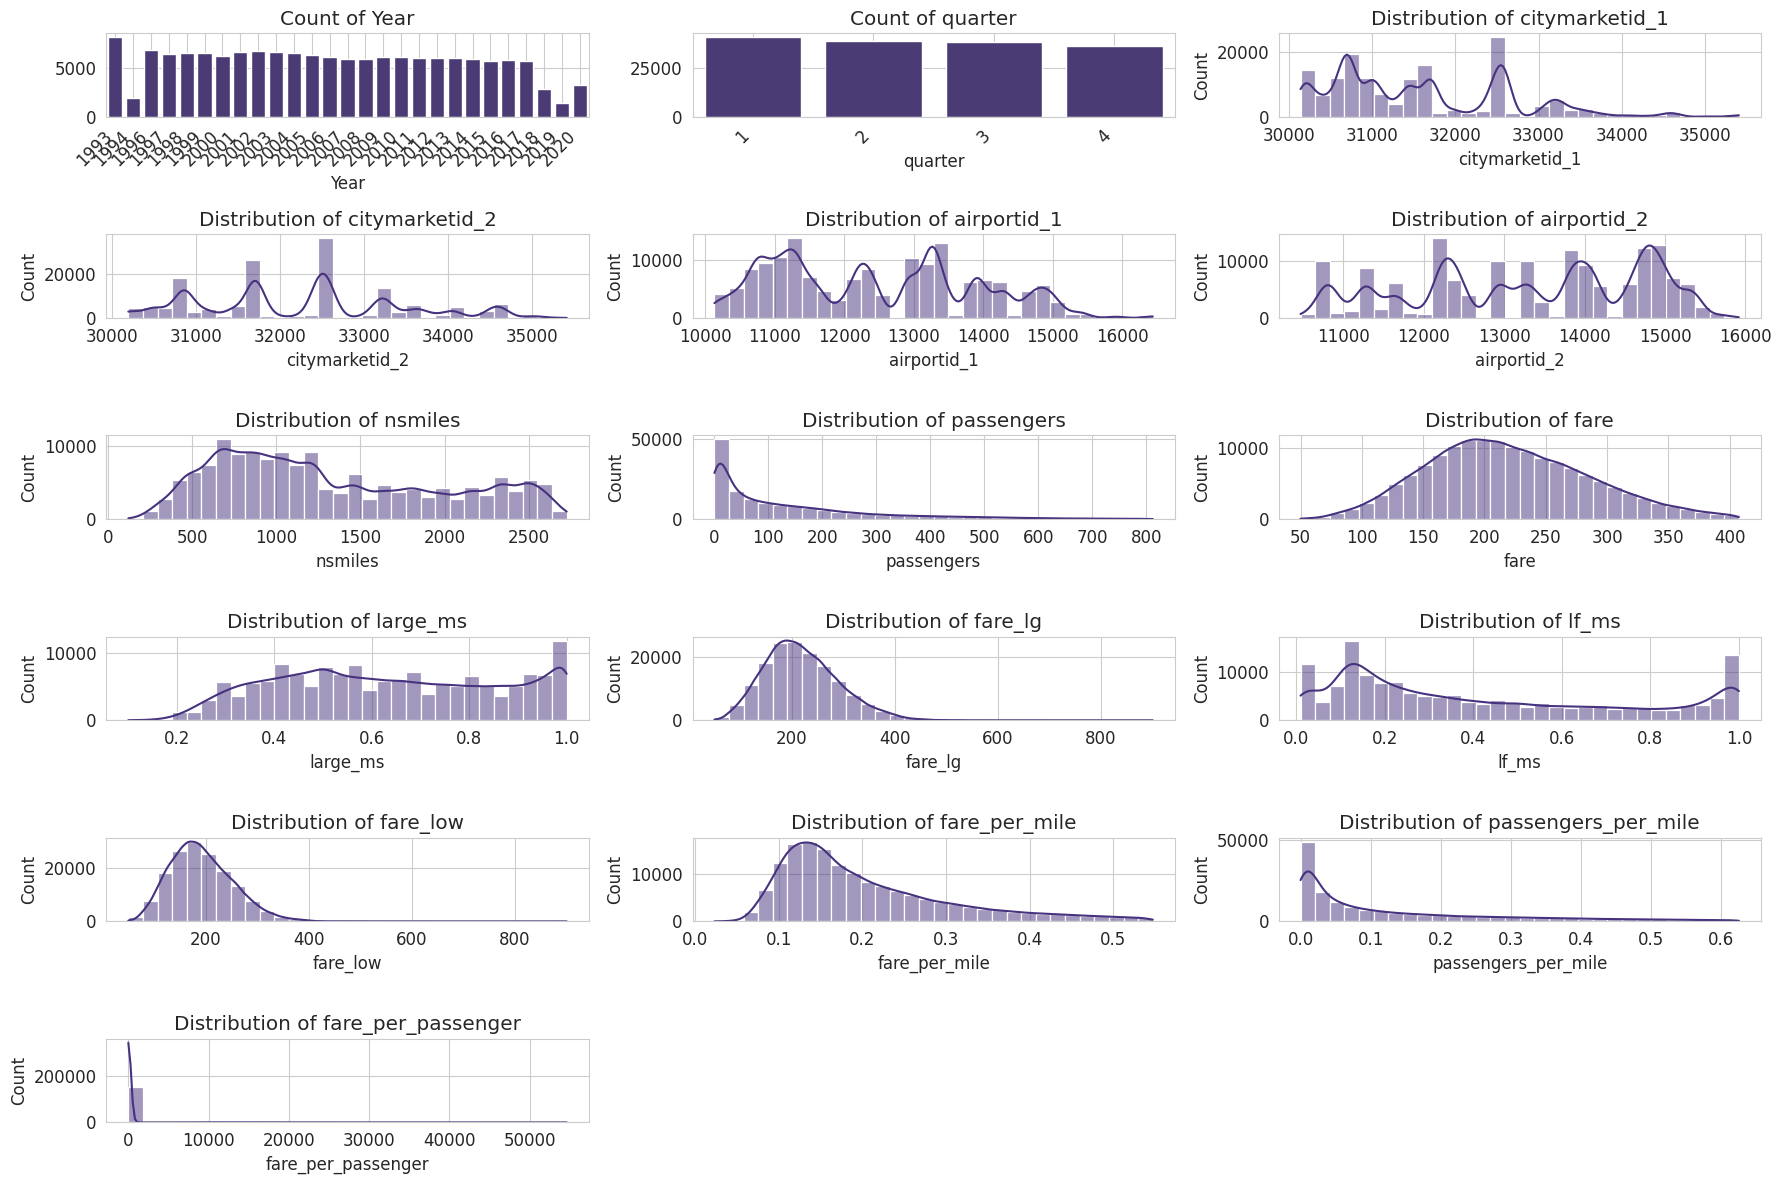


city1 has 135 unique values. Skipping plot.

city2 has 120 unique values. Skipping plot.

airport_1 has 151 unique values. Skipping plot.

airport_2 has 136 unique values. Skipping plot.

carrier_lg has 61 unique values. Skipping plot.

carrier_low has 62 unique values. Skipping plot.

Geocoded_City1 has 235 unique values. Skipping plot.

Geocoded_City2 has 204 unique values. Skipping plot.


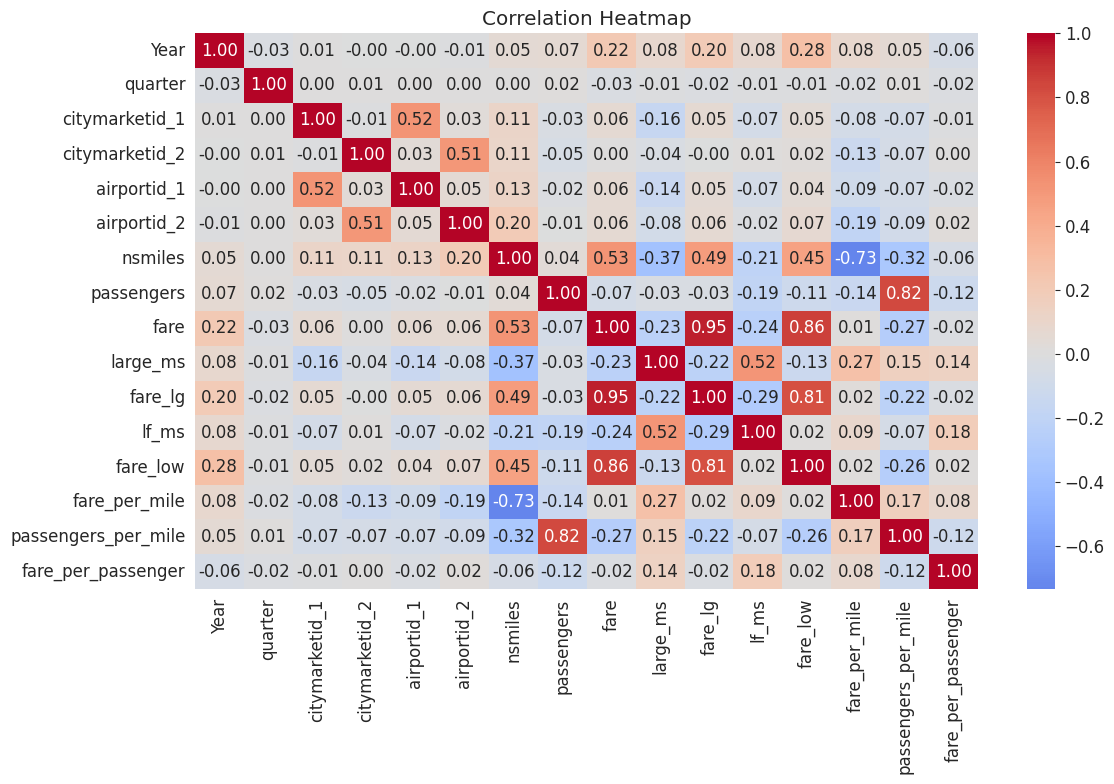

In [24]:
def plot_distributions(df, columns, ncols=3, figsize=(18, 12)):
    """Plot distributions of numerical columns."""
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    i = 0
    for i, col in enumerate(columns):
        if col in df.columns:
            if df[col].nunique() > 60:  # For continuous variables
                sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
                axes[i].set_title(f'Distribution of {col}')
            else:  # For categorical or discrete variables
                value_counts = df[col].value_counts().sort_values(ascending=False)
                sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
                axes[i].set_title(f'Count of {col}')
                plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Plot distributions of numerical columns
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
plot_distributions(df_clean, num_cols)

# Plot categorical distributions
cat_cols = [
    col for col in df_clean.select_dtypes(include=['object']).columns
    if not df_clean[col].apply(lambda x: isinstance(x, list)).any()
]
for col in cat_cols:
    if df_clean[col].nunique() < 60:  # Only plot if reasonable number of categories
        plt.figure(figsize=(10, 6))
        sns.countplot(y=col, data=df_clean,
                     order=df_clean[col].value_counts().index)
        plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n{col} has {df_clean[col].nunique()} unique values. Skipping plot.")

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = df_clean.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()